# Unsupervised Spectral Unmixing with Autoencoders

By Joshua C. Agar, Shuyu Qin


- There are many times where you want to extract imporant features from high-dimensional data


- In essence, the goal is to compress data to some lower latent space where you can extract information


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/3-swissroll-unfolded.png?raw=true)


## Autoencoder

![imag](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/Autoencoder.png?raw=true)


- **Encoder** - Neural network that deconstructs the data into the most important statistical components


- **Embedding Layer(s)** - One or many layers were information is extracted


- **Decoder** - Neural network that translates the latent space to original dimensionality.


### Mathematical Objective


- Minimize the reconstruction loss based on some metric.
  - Mean squared error


- Good at avoiding influence of anomalies
  - Mean absolute error


- Good at capturing details within spectra


### Optimizers


- Standard optimizers like ADAM tend to be sufficient


- Can use more complex optimizers 2nd order, adhessian to optimize small models.


### Practical Objective


- Create an autoencoder that has performant reconstruction


- Create a low-dimensional and interpretable latent space
  - Reduce the dimensionality
  - Impose non-negativity contraints
  - Impose regularization
  - Impose sparsity
  - Impose constraints on the shape of the latent distribution
  - Impose soft-constraints that favor disentanglement


- Create a latent trajectory that is suitable for generation


# Imports Packages


In [2]:
# installs the tutorial package
!pip install m3_learning --no-deps
!pip install -r tutorial_requirements.txt

     ---------------------------------------- 32.6/32.6 MB 9.1 MB/s eta 0:00:00
  Obtaining dependency information for traits>=4.5.0 from https://files.pythonhosted.org/packages/97/4f/3d0db984928b6275404f8dcbf777435717d52deea3cac3831a944d51d644/traits-6.4.2-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for natsort from https://files.pythonhosted.org/packages/ef/82/7a9d0550484a62c6da82858ee9419f3dd1ccc9aa1c26a1e43da3ecd20b0d/natsort-8.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for requests from https://files.pythonhosted.org/packages/70/8e/0e2d847013cb52cd35b38c009bb167a1a26b2ce6cd6965bf26b47bc0bf44/requests-2.31.0-py3-none-any.whl.metadata
  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
  Obtaining dependency information for dill from https://files.pythonhosted.org/packages/f5/3a/74a29b11cf2cdfcd6ba89c0cecd70b37cd1ba7b77978ce611eb7a146a832/dill-0.3.7-py3-none-any.whl.metadata
     ------------------------------------- 298.

DEPRECATION: sidpy 0.11 has a non-standard dependency specifier distributed>=2.0.0psutil. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of sidpy or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\jca92\\.conda\\envs\\tutorials\\Lib\\site-packages\\~umpy\\.libs\\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll'
Consider using the `--user` option or check the permissions.



In [16]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import inspect

from m3_learning.util.code import print_code


# from m3_learning.viz.nn import embeddings, latent_generator
# from m3_learning.nn.random import random_seed
# from m3_learning.viz.style import set_style
# from m3_learning.nn.time_series_nn.nn_util import Train, transform_nn, loss_function
# from m3_learning.viz.layout import layout_fig, embedding_maps
from m3_learning.util.data_generators import generate_data
# from skimage import io

# import copy
# from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
# import torch.nn.functional as F
# import torch.autograd as autograd
# import torch.optim as optim
# from tqdm import tqdm
# import os
# from torchsummary import summary

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# set_style("printing")
# random_seed(seed=42)

# %matplotlib inline


# Generating Data


- We want to generate a hyperspectral image


- This can be done by taking the RGB values of an image and using them as parameters for a function


## Loads and image of my dog Nala

- Painting by _Irene Dogmatic_


In [17]:
# Loads dog image
image = io.imread(
    "https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/nala.jpg?raw=true"
)

# Crops dog image
image = image[200:1900:20, 100:1500:20] / 255


## Displays the image


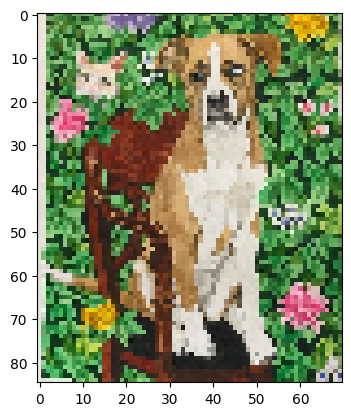

In [18]:
# Plots dog image
plt.imshow(image)


## Generating some data based on the image

### Define a non-linear function


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/generated.png?raw=true)


In [19]:
def non_linear_fn(t, x, y, z):
    tanh = nn.Tanh()
    selu = nn.SELU()
    sigmoid = nn.Sigmoid()

    # returns a function from variables
    return (
        tanh(torch.tensor(20 * (t - 2 * (x - 0.5))))
        + selu(torch.tensor((t - 2 * (y - 0.5))))
        + sigmoid(torch.tensor(-20 * (t - (z - 0.5))))
    )


In [22]:
print_code(generate_data)

24: def generate_data(values, function=default_nl_function, length=25, range_=[-1, 1]):
25:   """function to generate data based on an arbitrary function
26: 
27:   Args:
28:       values (array): Input values to use
29:       function (obj, optional): Function to use for generation. Defaults to default_nl_function.
30:       length (int, optional): length of the vector to generate. Defaults to 25.
31:       range_ (list, optional): range of spectra where you generate data. Defaults to [-1, 1].
32: 
33:   Returns:
34:       array: computed spectra
35:   """
36:   # build x vector
37:   x = np.linspace(range_[0], range_[1], length)
38: 
39:   data = np.zeros((values.shape[0], length))
40: 
41:   for i in range(values.shape[0]):
42:       data[i, :] = function(x, values[i, 0], values[i, 1], values[i, 2])
43: 
44:   return data
45: 


In [20]:
# generates a hyperspectral image
dog_data = generate_data(image.reshape(-1, 3),
                         length=10, function=non_linear_fn)


In [ ]:
# Conducts a test train split.
# because we are training an autoencoder x and y are the same
X_train, X_test, _, _ = train_test_split(
    dog_data, dog_data, test_size=0.2, random_state=42
)


## Plots the generated data


In [ ]:
fig, ax = layout_fig(6, mod=3, figsize=(5, 2.5))

ax = ax.ravel()

cmap = plt.cm.viridis

for i, ax in enumerate(ax):
    if i < 3:
        # imagemap(ax, image[:, :, i],divider_=False, clim = (0,1))
        img = np.zeros(image.shape)
        img[:, :, i] = image[:, :, i]
        ax.imshow(img)
    else:
        values = np.zeros((5, 3))
        values[:, i - 3] = np.linspace(0, 1, 5)
        y_data = generate_data(values, length=10)
        for j in range(y_data.shape[0]):
            color = cmap((j + 1) / y_data.shape[0])
            ax.plot(y_data[j], c=color)


## Building a Simple Autoencoder


### Defines the encoder and the decoder


In [ ]:
latent_dim = 12


class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.dense_1 = nn.Linear(10, self.latent_dim)

    def forward(self, x):
        # single dense layer in the model
        x = self.dense_1(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.dense_1 = nn.Linear(self.latent_dim, 10)

    def forward(self, x):
        # single dense layer in the decoder
        x = self.dense_1(x)
        return x


### Builds the autoencoder


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        # encode
        embedding = self.encoder(x)
        # decode
        predicted = self.decoder(embedding)

        return predicted


### Instantiates the model


In [ ]:
import cpuinfo

cpudata = cpuinfo.get_cpu_info()["brand_raw"]
cpuname = cpudata.split(" ")[1]

if cpuname == "M1":
    device = "mps"
elif torch.cuda.device_count():
    device = "cuda"
else:
    device = "cpu"

print(f"You are running on a {device}")

encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


In [ ]:
try:
    summary(model, ((X_train.shape[1:])))
except:
    model_cpu = copy.deepcopy(model).to("cpu")
    summary(model_cpu, ((X_train.shape[1:])))


- Encoder with 12 latent dimensions
- Decoder with with size 10 --> same as orignal spectral length
- Autoencoder considers time by saying each timestep is its own fully-uncorrelated sample


### Builds the dataloader


In [ ]:
train_iterator = torch.utils.data.DataLoader(
    X_train, batch_size=256, shuffle=True)


### Trains the model


In [ ]:
random_seed(seed=42)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


### Evaluates the model after training


In [ ]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


In [ ]:
embeddings(encode, shape_=image.shape[0:2], figsize=(5, 3), clim=(-2, 2))


- This is clearly an overcomplete example since we are learning 10 timesteps with 12 latent variables


- We know that we only have 3 intrinsic latent variables


## Model with 3 latent variables

### Instantiates the model (3 latent variables)


In [ ]:
encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


In [ ]:
summary(model, ((X_train.shape[1:])))


- Encoder with 3 latent dimensions
- Decoder with with size 10 --> same as orignal spectral length
- Autoencoder considers time by saying each timestep is its own fully-uncorrelated sample


In [ ]:
train_iterator = torch.utils.data.DataLoader(
    X_train, batch_size=256, shuffle=True)


### Trains the model


In [ ]:
random_seed(seed=42)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


In [ ]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


In [ ]:
embeddings(encode, shape_=image.shape[0:2], figsize=(4.5, 1.25))


- This is clearly an overcomplete example since we are learning 10 timesteps with 12 latent variables


### Generator

- Now we want to see how the spectra changes as we traverse the latent space


In [ ]:
latent_generator(decoder, encode, image, 5, 10, device=device,
                 figsize=(5, 2.5), divider_=False)


## Recurrent Neural Network Autoencoders


- The above example did not consider the temporal information in the data.


- This can be improved by using a recurrent neural network that processes each time step sequentially.


- To add an understanding about the short and long term information in the data you can add memory and forget logic as a learnable parameter.


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/Autoencoder_Med.png?raw=true)


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/LSTM%20Node.png?raw=true)


### Builds the model


In [ ]:
latent_dim = 12

# input (batch,)


class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12,
                            batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [ ]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


### Dataloader


In [ ]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


### Training


In [ ]:
random_seed(seed=42)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


### Validation


In [ ]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


In [ ]:
embeddings(encode, shape_=image.shape[0:2], figsize=(5, 3))


- This does not really mean too much because the latent variables are all competing with one another


## LSTM Autoencoder with 3 Latent Variables


In [ ]:
encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [ ]:
model


### Dataloader


In [ ]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


### Training


In [ ]:
random_seed(seed=42)

Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


### Validation


In [ ]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


In [ ]:
embeddings(encode, shape_=image.shape[0:2], figsize=(4.5, 1.25))


In [ ]:
latent_generator(decoder, encode, image, 5, 10, device=device,
                 figsize=(5, 2.5), divider_=False)


- This once again is very hard to interpret and the spectra do not really contain the necessary details


## Disentanglement

### Regularization

![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/L1_reg.png?raw=true)


### Builds the Model


In [ ]:
latent_dim = 12

# input (batch,)


class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        x = self.relu(x)  # add a relu
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12,
                            batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [ ]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [ ]:
model


### Dataloader


In [ ]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


### Training


In [ ]:
random_seed(seed=42)

Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    500,
    coef=1e-3,
    mse=False,
    device=device,
)


### Validation


In [ ]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


In [ ]:
embeddings(encode, shape_=image.shape[0:2], figsize=(4.5, 3.75))


In [ ]:
latent_generator(decoder, encode, image, 5, 10, device=device,
                 figsize=(5, 2.5), divider_=False, indx=[2, 8, 9])


In [ ]:
fig, ax = layout_fig(6, mod=3)

ax = ax.ravel()

cmap = plt.cm.viridis

for i, ax in enumerate(ax):
    if i < 3:
        img = np.zeros(image.shape)
        img[:, :, i] = image[:, :, i]
        ax.imshow(img)
    else:
        values = np.zeros((5, 3))
        values[:, i - 3] = np.linspace(0, 1, 5)
        y_data = generate_data(values, length=10)
        for j in range(y_data.shape[0]):
            color = cmap((j + 1) / y_data.shape[0])
            ax.plot(y_data[j], c=color)


In [ ]:
from IPython.display import HTML

# Youtube
HTML(
    '<iframe width="560" height="315" src="https://www.youtube.com/embed/ElTwQClLsW0" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)


## Beta Variational Autoencoder

- Constrict and sample the latent space from some prior distribution --> generally a gaussian distribution


### Normal Autoencoder

![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/VAE1.png?raw=true)


### VAE

- Encoder identifies some distribution --> generates from that distribution
  ![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/VAE2.png?raw=true)


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/VAE3.png?raw=true)


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/VAE4.png?raw=true)


### Builds the Model


In [ ]:
latent_dim = 12

# input (batch,)


class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()
        self.mn = nn.Linear(self.latent_dim, self.latent_dim)
        self.sd = nn.Linear(self.latent_dim, self.latent_dim)

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        x = self.relu(x)
        mn = self.mn(x)
        sd = self.sd(x)
        std = torch.exp(sd * 0.5).cuda()
        eps = torch.normal(0, 1, size=std.size()).cuda()
        out = eps.mul(std).add_(mn).cuda()

        return out, mn, sd


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(
            latent_dim, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [ ]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


### Training


In [ ]:
def Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    epochs,
    coef=0,
    coef_1=0,
    ln_parm=1,
    beta_step_size=0,
    epoch_per_beta=10,
    initial_epochs=10,
    device=device,
    save=False,
):

    N_EPOCHS = epochs
    best_train_loss = float("inf")

    for epoch in range(N_EPOCHS):

        if epoch < initial_epochs:

            beta = 0
        else:

            beta = ((epoch - initial_epochs) //
                    epoch_per_beta + 1) * beta_step_size

        train_loss = loss_function(
            model,
            encoder,
            decoder,
            train_iterator,
            optimizer,
            coef,
            coef_1,
            ln_parm,
            beta=beta,
            mse=False,
        )

        train_loss /= len(train_iterator)
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}")
        print(".............................")

        if save:
            if (
                (epoch - initial_epochs) // epoch_per_beta
                == (epoch - initial_epochs) / epoch_per_beta
            ) and (epoch >= initial_epochs):

                best_train_loss = float("inf")

            if best_train_loss > train_loss:
                best_train_loss = train_loss
                patience_counter = 1
                checkpoint = {
                    "net": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "epoch": epoch,
                    "encoder": encoder.state_dict(),
                    "decoder": decoder.state_dict(),
                }
                if epoch >= 0:
                    torch.save(
                        checkpoint, f"./test__Train_Loss:{train_loss:.4f}-{epoch}.pkl"
                    )


In [ ]:
random_seed(seed=42)

Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    500,
    beta_step_size=0.05,
    epoch_per_beta=100,
    initial_epochs=200,
    device=device,
)


### Validation


In [ ]:
encoded_spectra, mn, sd = encoder(
    torch.tensor(np.atleast_3d(dog_data), dtype=torch.float32).to(device)
)
decoded_spectra = decoder(encoded_spectra)


In [ ]:
encoded_spectra = encoded_spectra.to("cpu")
encoded_spectra = encoded_spectra.detach().numpy()
decoded_spectra = decoded_spectra.to("cpu")
decoded_spectra = decoded_spectra.detach().numpy()


In [ ]:
embeddings(encoded_spectra, shape_=image.shape[0:2], figsize=(4.5, 3.75))


In [ ]:
latent_generator(decoder, encoded_spectra, image, 5, 10,
                 device=device, figsize=(5, 2.5), divider_=False, indx=[1, 3, 4])


- disentanglement with $\beta$ VAE requires careful control of optimiztion.
